## BenchMarks
This notebook is to compare different version of PyRuSH regarding speed. First, install some packages.

### Get some clinical notes from mtsamples.com

In [1]:
%%capture
!pip install beautifulsoup4 ipywidgets matplotlib numpy

In [1]:
from bs4 import BeautifulSoup 
import requests,re
from ipywidgets import IntProgress
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import pickle,os

In [2]:
max_count = 100
if os.path.exists('data_dump.pkl'):
    with open('data_dump.pkl', 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        docs = pickle.load(f)
else:
    print('No data dump file exist, need to generate some data...')   

In [11]:
def get_page_urls(prefix:str='https://www.mtsamples.com/site/pages/browse.asp?type=6-Cardiovascular+%2F+Pulmonary&page=',page_ids:[]=[1,]):
    urls=OrderedDict()
    for i in page_ids:
        url=prefix+str(i)
        content= requests.get(url).text
        soup = BeautifulSoup(content)
        for link in soup.findAll('a', attrs={'href': re.compile("^/site/pages/sample.asp")}):
            urls['https://www.mtsamples.com'+link['href']]=None
    return list(urls.keys())

In [12]:
def get_format_text(url:str):
    content= requests.get(url).text
    soup = BeautifulSoup(content)
    main=soup.find("div", {"id": "sampletext"})
    if main is None:
        return ''
    h1=main.h1
    if h1 is None:
        return ''
    output=[]
    for s in h1.next_siblings:
        if s.name == 'div':
            break       
        if s.string is not None:
            if 'MTSam' in s.string:
                continue
            output.append(s.string)
    return '\n'.join(output)

In [13]:
docs=[]
urls=get_page_urls()
if max_count>len(urls):
    max_count=len(urls)
f = IntProgress(min=0, max=max_count) 
display(f)
for url in urls[:max_count]:
    f.value += 1 
    doc =get_format_text(url)
    docs.append(doc)

IntProgress(value=0)

#### Need to dump the docs data?

In [41]:
if not os.path.exists('data_dump.pkl'):
    with open('data_dump.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(docs, f, pickle.HIGHEST_PROTOCOL)
else:
    print("data dump already exists, skip pickling.")

data dump already exists, skip pickling.


In [3]:
data=np.array([len(doc) for doc in docs])
data.min(),data.max()


(597, 9672)

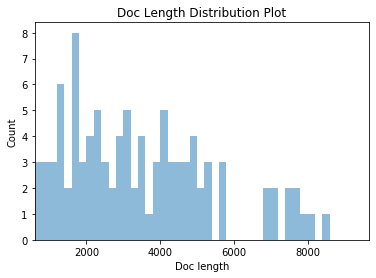

In [4]:
bins = np.arange(400, 9000, 200)
plt.xlim([min(data)-5, max(data)+5])
plt.hist(data, bins=bins, alpha=0.5)
plt.title('Doc Length Distribution Plot')
plt.xlabel('Doc length')
plt.ylabel('Count')
plt.show()

### Benchmark legacy version

In [5]:
%%capture
!pip install -U pyrush==1.0.2 pyfastner==1.0.8.dev1 intervaltree==2.1.0

In [6]:
def process(seg_func, docs):
    f = IntProgress(min=0, max=max_count) 
    clear_output()
    display(f)
    for doc in docs:
        f.value += 1 
        seg_func(doc)

### Init PyRuSH

In [7]:
from PyRuSH.RuSH import RuSH
rush = RuSH('../conf/rush_rules.tsv')

In [8]:
%%timeit -r 5 -n 1
process(rush.segToSentenceSpans, docs)

IntProgress(value=0)

15.7 s ± 176 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


### Benchmark new version

Reboot the notebook kernal, in case the loaded class won't clear out.

In [5]:
%%capture
!pip install -U pyrush==1.0.3 PyFastNER==1.0.8b1

Note: The new version simplified the import syntax

In [6]:
from PyRuSH.RuSH import RuSH as RuSH3
rush3 = RuSH3('../conf/rush_rules.tsv',auto_fix_gaps=False)

/home/brokenjade/Documents/PycharmProjects/PyRuSH/notebooks/../conf/rush_rules.tsv


In [11]:
%%timeit -r 5 -n 1
process(rush3.segToSentenceSpans, docs)

IntProgress(value=0)

14.7 s ± 227 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


The difference isn't that much, likely because the PyFastNER are still running native python code, switch a intervaltree implementation may not contribute significantly. Cythonize PyFastNER is next step.

### Try older PyRuSH on new PyFastNER

In [3]:
%%capture
!pip install -U pyrush==1.0.2 PyFastNER==1.0.8b1

In [4]:
from PyRuSH.RuSH import RuSH
rush = RuSH('../conf/rush_rules.tsv')

/home/brokenjade/Documents/PycharmProjects/PyRuSH/notebooks/../conf/rush_rules.tsv


In [7]:
%%timeit -r 5 -n 1
process(rush.segToSentenceSpans, docs)

IntProgress(value=0)

14.8 s ± 267 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
